In [6]:
!pip install praat-textgrids

You should consider upgrading via the 'D:\Acads\Semester 9\Thesis\Code\vad\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [10]:
import textgrids

FRAME_DURATION = 30 # 30 msec
OVERLAP_RATE = 0.0 # frames don't overlap

def readFile(path):
    '''
    Read the file and return the list of SPEECH/NONSPEECH labels for each frame
    '''

    labeled_list  = []
    grid = textgrids.TextGrid(path)

    for interval in grid['silences']:
        label = int(interval.text)

        dur = interval.dur
        dur_msec = dur * 1000 # sec -> msec
        num_frames = int(round(dur_msec /30)) # the audio is divided into 30 msec frames
        print(dur_msec)
        for i in range(num_frames):

            labeled_list.append(label)

    return labeled_list

ModuleNotFoundError: No module named 'textgrids'

In [ ]:
import librosa

root ='/content/data'
annotation_path = "/content/data/annotation/mic_M10_si2186.TextGrid"
audio_path = "/content/data/audio/mic_M10_si2186.wav"

# read annotaion
label_list = readFile(annotation_path)

# read wav file
data, fs = librosa.load(audio_path)

In [8]:
Ns = len(data)  # number of sample
Ts = 1 / fs  # sampling period
t = np.arange(Ns) * 1000 * Ts  # time axis


shift = 1 - OVERLAP_RATE
frame_length = int(np.floor(FRAME_DURATION * fs / 1000)) # frame length in sample
frame_shift = round(frame_length * shift)# frame shift in sample

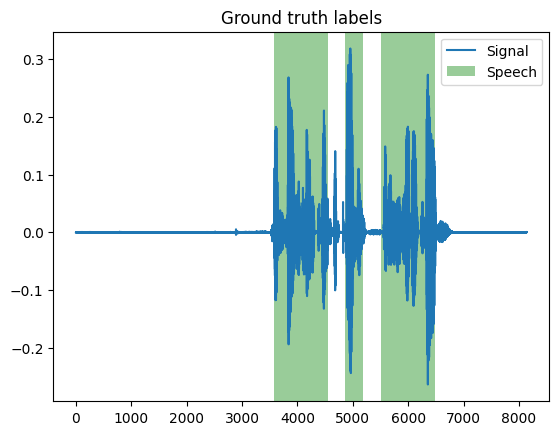

In [9]:
import matplotlib.pyplot as plt

figure = plt.Figure(figsize=(10, 7), dpi=85)
plt.plot(t, data)

for i, frame_labeled in enumerate(label_list):
    idx = i * frame_shift
    if (frame_labeled == 1):
        plt.axvspan(xmin= t[idx], xmax=t[idx + frame_length-1], ymin=-1000, ymax=1000, alpha=0.4, zorder=-100, facecolor='g', label='Speech')

plt.title("Ground truth labels")
plt.legend(['Signal', 'Speech'])
plt.show()

In [10]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5867 sha256=42992c08a751a3201cf5f5490dddc5a4518238a07755d4f202d170ac49198a16
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [11]:
import os # Working with directories
import python_speech_features # For exctracting features for deep learning
from tqdm import tqdm # Progress meter
from sklearn import model_selection, preprocessing, metrics # Preparation data
from tensorflow.keras import models, layers
import tensorflow as tf

In [12]:
def readLabels(path, sample_rate):
    '''
    Read the file and return the list of SPEECH/NONSPEECH labels for each frame
    '''

    labeled_list  = []
    grid = textgrids.TextGrid(path)

    for interval in grid['silences']:
        label = int(interval.text)

        dur = interval.dur
        dur_samples = int(np.round(dur * sample_rate)) # sec -> num of samples

        for i in range(dur_samples):
            labeled_list.append(label)

    return labeled_list

In [13]:
def getFiles(path, extension):
    list_paths = list()
    for root, dirs, files in os.walk(path):
        for file in files:
            if(file.endswith(extension)):
                list_paths.append(os.path.join(root, file))
    return list_paths

In [14]:
annotation_path = 'Data\Data\Annotation\Noizeus\Babble'
annotation_extension = '.TextGrid'
audio_path = 'ata\Data\Audio\Noizeus\Babble'
audio_extension = '.wav'

annotation_files = getFiles(path=annotation_path, extension=annotation_extension)
audio_files = getFiles(path=audio_path, extension=audio_extension)
annotation_files = sorted(annotation_files)
audio_files = sorted(audio_files)

print('Number of files:', len(audio_files))

Number of files: 12


In [15]:
preemphasis_coef = 0.97 # Coefficient for pre-processing filter
frame_length = 0.025 # Window length in sec
frame_step = 0.01 # Length of step in sec
num_nfft = 512 # Point for FFT
num_features = 32 # Number of Mel filters
n_frames = 32 # Number of frames for uniting in image

In [16]:
dataset = list()
for i in tqdm(range(len(audio_files))):
    sig, sample_rate = librosa.load(audio_files[i])
    markers = readLabels(path=annotation_files[i], sample_rate=sample_rate)

    # Extract logfbank features:
    features_logfbank = python_speech_features.base.logfbank(signal=sig, samplerate=sample_rate, winlen=frame_length, winstep=frame_step, nfilt=num_features,
                                                                        nfft=num_nfft, lowfreq=0, highfreq=None, preemph=preemphasis_coef)

    # Reshape labels for each group of features:
    markers_of_frames = python_speech_features.sigproc.framesig(sig=markers, frame_len=frame_length * sample_rate, frame_step=frame_step * sample_rate,
                                                                winfunc=np.ones)

    # For every frame calc label:
    marker_per_frame = np.zeros(markers_of_frames.shape[0])
    marker_per_frame = np.array([1 if np.sum(markers_of_frames[j], axis=0) > markers_of_frames.shape[0] / 2 else 0 for j in range(markers_of_frames.shape[0])])

    spectrogram_image = np.zeros((n_frames, n_frames))
    for j in range(int(np.floor(features_logfbank.shape[0] / n_frames))):
        spectrogram_image = features_logfbank[j * n_frames:(j + 1) * n_frames]
        label_spectrogram_image = 1 if np.sum(marker_per_frame[j * n_frames:(j + 1) * n_frames]) > n_frames / 2 else 0
        dataset.append((label_spectrogram_image, spectrogram_image))

100%|██████████| 12/12 [00:01<00:00,  6.43it/s]


In [17]:
markers_of_frames.shape

(760, 551)

In [18]:
X = list()
y = list()
for i in range(len(dataset)):
    X.append(dataset[i][1])
    y.append(dataset[i][0])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, shuffle=True, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Reshaping for scaling:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

# Scale data:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# And reshape back:
X_train = X_train.reshape(X_train.shape[0], n_frames, n_frames)
X_test = X_test.reshape(X_test.shape[0], n_frames, n_frames)

(183, 32, 32) (91, 32, 32) (183,) (91,)


In [19]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [20]:
stride = int(15)

X_train_reshaped = X_train[:int(np.floor(X_train.shape[0] / stride) * stride)]
X_test_reshaped = X_test[:int(np.floor(X_test.shape[0] / stride) * stride)]

y_train_reshaped = y_train[:int(np.floor(X_train.shape[0] / stride) * stride)]
y_test_reshaped = y_test[:int(np.floor(X_test.shape[0] / stride) * stride)]

X_train_reshaped = X_train_reshaped.reshape((int(X_train_reshaped.shape[0] / stride), stride, n_frames, n_frames, 1))
X_test_reshaped = X_test_reshaped.reshape((int(X_test_reshaped.shape[0] / stride), stride, n_frames, n_frames, 1))

y_train_reshaped = y_train_reshaped.reshape((int(y_train_reshaped.shape[0] / stride), stride, y_train[-1].shape[0]))
y_test_reshaped = y_test_reshaped.reshape((int(y_test_reshaped.shape[0] / stride), stride, y_test[-1].shape[0]))

In [21]:
X_train_reshaped.shape

(12, 15, 32, 32, 1)

In [22]:
model = models.Sequential()
model.add(layers.TimeDistributed(layers.Conv2D(64, (5, 5), activation='elu'), input_shape=(stride, n_frames, n_frames, 1)))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='elu')))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='elu')))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Flatten()))
model.add(layers.TimeDistributed(layers.Dense(64, activation='elu')))
model.add(layers.Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
model.add(layers.Dropout(0.5))
model.add(layers.TimeDistributed(layers.Dense(y_train[-1].shape[0], activation='softmax')))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


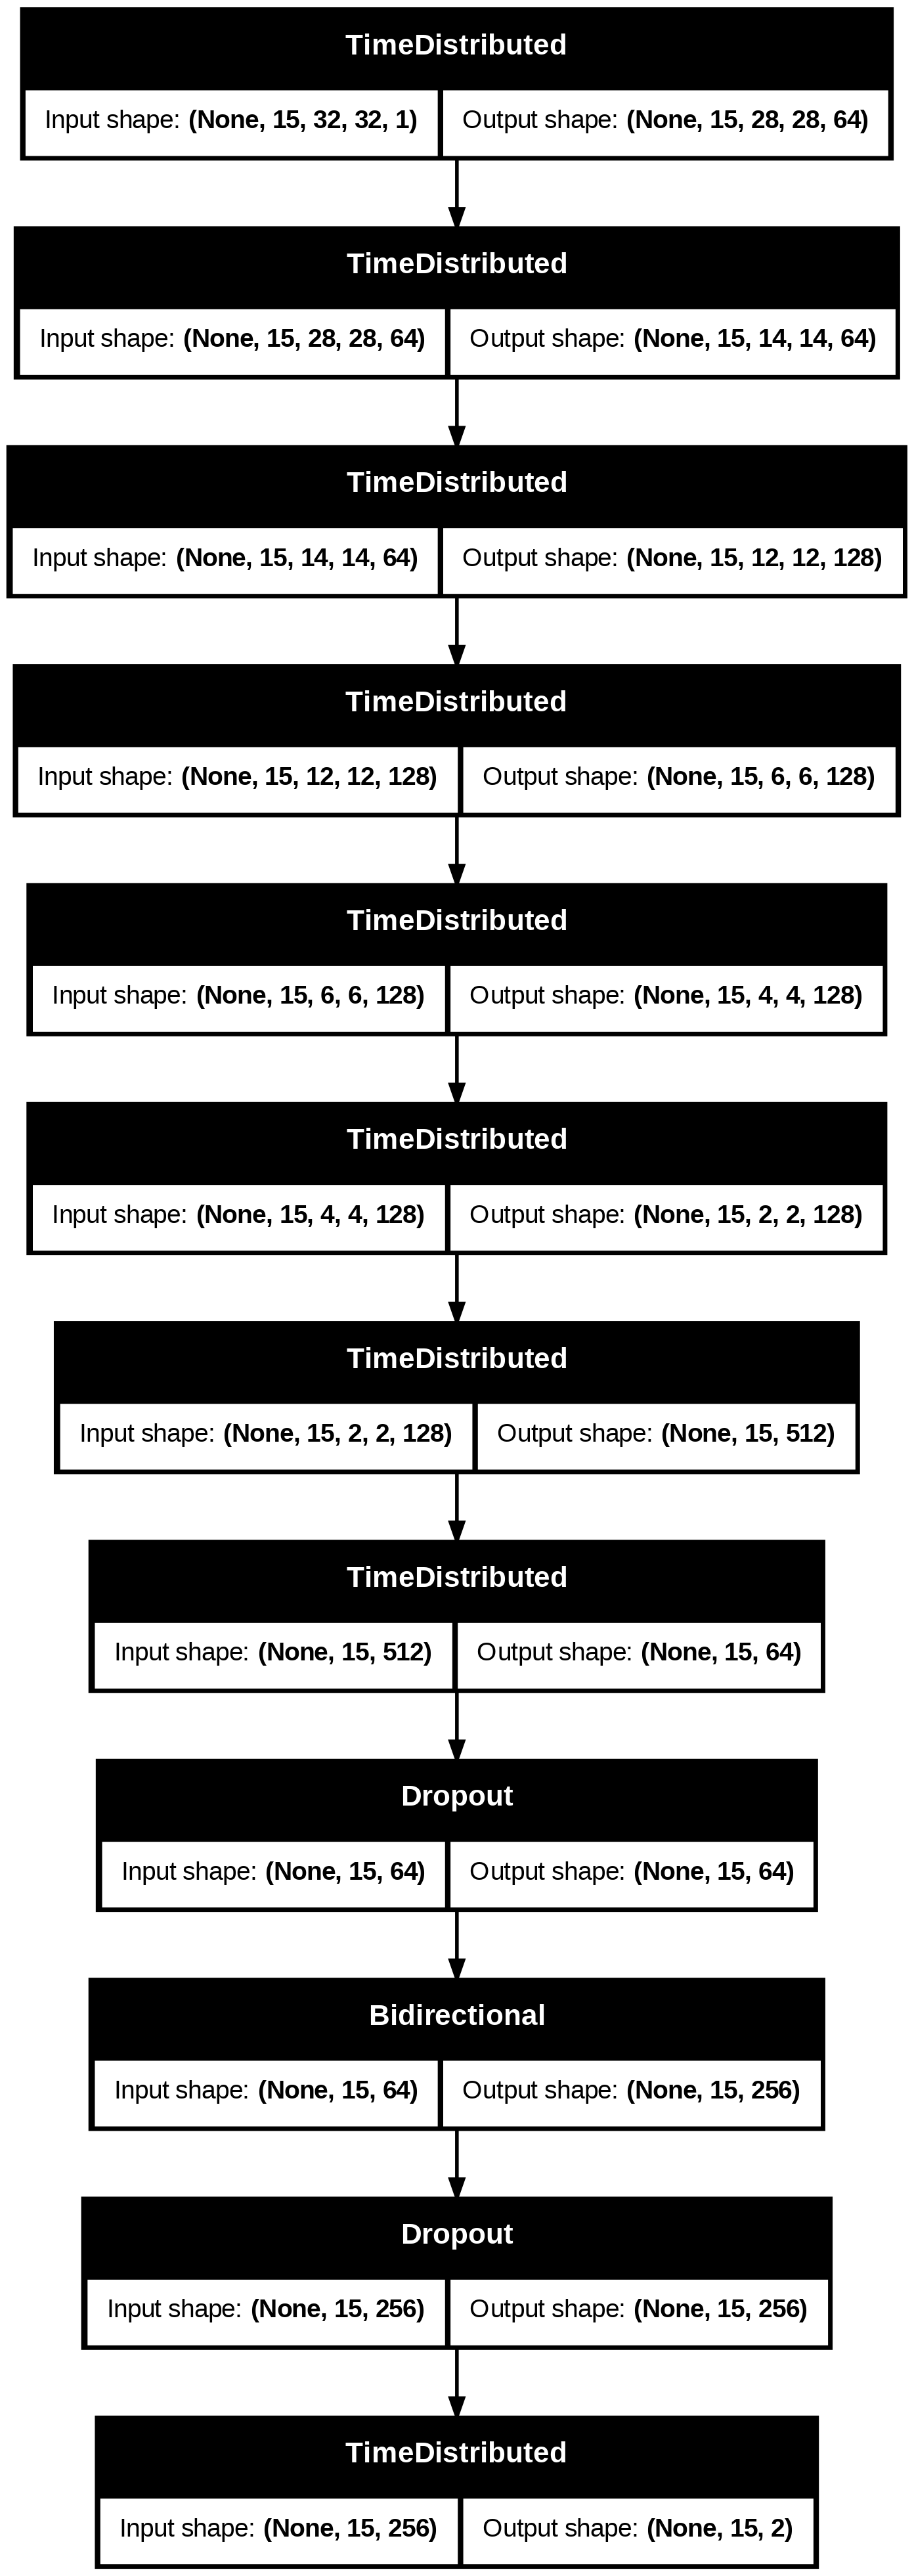

In [23]:
from tensorflow.keras.utils import plot_model

plot_model(model, 'model.png', show_shapes=True)

In [24]:
epochs = 25
batch_size = 32
callbacks = None

history = model.fit(
    X_train_reshaped, y_train_reshaped,
    validation_data=(X_test_reshaped, y_test_reshaped),
    epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.6389 - loss: 0.6823 - val_accuracy: 0.9000 - val_loss: 0.4345
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8500 - loss: 0.4517 - val_accuracy: 0.8778 - val_loss: 0.3112
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8444 - loss: 0.3452 - val_accuracy: 0.8778 - val_loss: 0.2679
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8667 - loss: 0.2966 - val_accuracy: 0.9111 - val_loss: 0.2019
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8889 - loss: 0.2837 - val_accuracy: 0.9444 - val_loss: 0.1464
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9222 - loss: 0.2224 - val_accuracy: 0.9444 - val_loss: 0.1326
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9333 - loss: 0.1834 - val_accuracy: 0.9444 - val_loss: 0.1439
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9222 - loss: 0.2054 - val_accuracy: 0.9444 - val_loss: 0.1479
Epoch 9/25
1/1

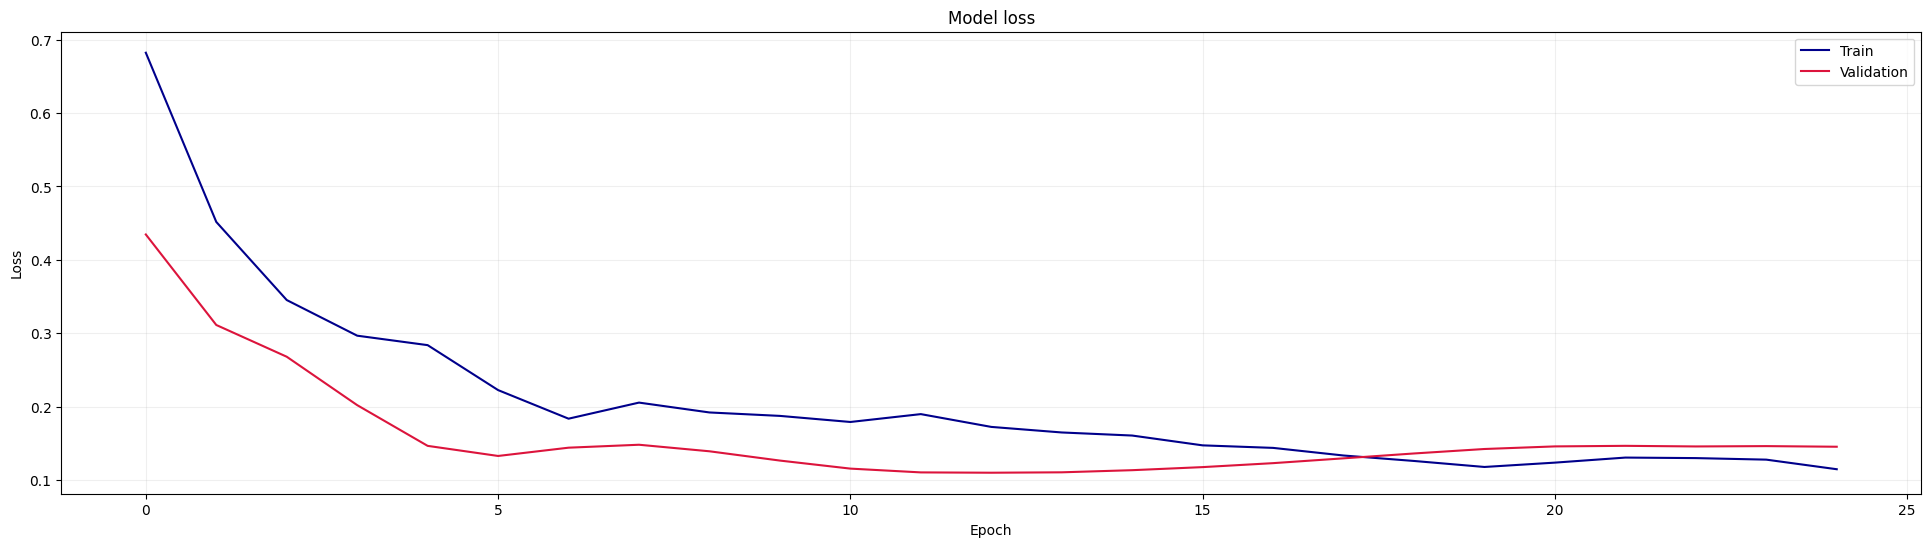

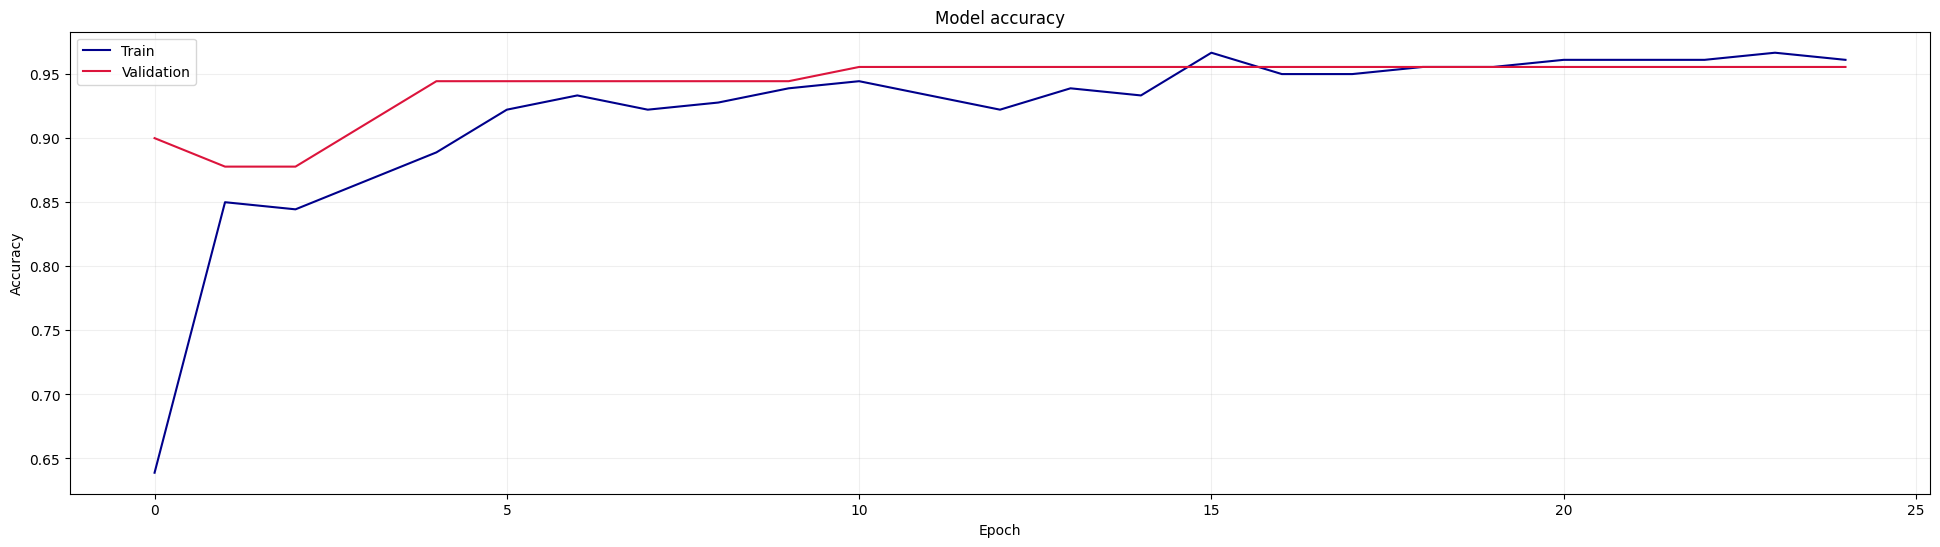

In [25]:
def plot_loss(history):
    plt.figure(figsize=(24, 6))
    plt.plot(history.history['loss'], c ="darkblue")
    plt.plot(history.history['val_loss'], c ="crimson")
    plt.legend(["Train", "Validation"])
    plt.title("Model loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, alpha = 0.2)
    plt.show()


def plot_accuracy(history):
    plt.figure(figsize=(24, 6))
    plt.plot(history.history['accuracy'], c ="darkblue")
    plt.plot(history.history['val_accuracy'], c ="crimson")
    plt.legend(["Train", "Validation"])
    plt.title("Model accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha = 0.2)
    plt.show()


plot_loss(history)
plot_accuracy(history)

In [42]:
annotation_file = "/content/data/annotation/mic_M10_si2192.TextGrid"
audio_file = "/content/data/audio/mic_M10_si2192.wav"

dataset_valid = list()

# Load samples:
input_signal, fs = librosa.load(audio_file)

# Load labels:
truth_labels = readLabels(path=annotation_file, sample_rate=fs)

# Extract logfbank features:
features_logfbank_valid = python_speech_features.base.logfbank(signal=input_signal, samplerate=fs, winlen=frame_length, winstep=frame_step, nfilt=num_features,
                                                               nfft=num_nfft, lowfreq=0, highfreq=None, preemph=preemphasis_coef)

# Reshape labels for each group of features:
marker_per_frames_truth = python_speech_features.sigproc.framesig(sig=truth_labels, frame_len=frame_length * fs, frame_step=frame_step * fs,
                                                                 winfunc=np.ones)

# For every frame calc label:
marker_per_frame_truth = np.zeros(marker_per_frames_truth.shape[0])
marker_per_frame_truth = np.array([1 if np.sum(marker_per_frames_truth[j], axis=0) > marker_per_frames_truth.shape[0] / 2 else 0
                                   for j in range(marker_per_frames_truth.shape[0])])

spectrogram_image_valid = np.zeros((n_frames, n_frames))
for j in range(int(np.floor(features_logfbank_valid.shape[0] / n_frames))):
    spectrogram_image_valid = features_logfbank_valid[j * n_frames:(j + 1) * n_frames]
    label_spectrogram_image_valid = 1 if np.sum(marker_per_frame_truth[j * n_frames:(j + 1) * n_frames]) > n_frames / 2 else 0
    dataset_valid.append((label_spectrogram_image_valid, spectrogram_image_valid))

In [43]:
if stride - len(dataset_valid) > 0:
    for i in range(stride - len(dataset_valid)):
        dataset_valid.append((0, np.zeros((n_frames, n_frames))))

In [44]:
X_valid = list()
y_valid = list()
for i in range(len(dataset_valid)):
    X_valid.append(dataset_valid[i][1])
    y_valid.append(dataset_valid[i][0])

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

# Reshaping for scaling:
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1] * X_valid.shape[2])

# Scale data:
X_valid = scaler.transform(X_valid)

# And reshape back:
X_valid = X_valid.reshape(X_valid.shape[0], n_frames, n_frames)

In [45]:
y_truth = y_valid
y_valid = pd.get_dummies(y_valid)
y_valid = np.array(y_valid)

In [46]:
X_valid_reshaped = X_valid[:int(np.floor(X_valid.shape[0] / stride) * stride)]
y_valid_reshaped = y_valid[:int(np.floor(X_valid.shape[0] / stride) * stride)]

X_valid_reshaped = X_valid_reshaped.reshape((int(X_valid_reshaped.shape[0] / stride), stride, n_frames, n_frames, 1))
y_valid_reshaped = y_valid_reshaped.reshape((int(y_valid_reshaped.shape[0] / stride), stride, y_valid[-1].shape[0]))

In [47]:
prediction = model.predict(X_valid_reshaped)

predicted_label = np.zeros(prediction.shape[1])
predicted_proba = np.zeros(prediction.shape[1])
ind = 0
for i in range(prediction.shape[1]):
    if prediction[0][i][0] >= prediction[0][i][1]:
        predicted_label[ind] = 0
        predicted_proba[ind] = prediction[0][i][0]
    else:
        predicted_label[ind] = 1
        predicted_proba[ind] = prediction[0][i][1]
    ind = ind + 1

predicted_label

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.])

In [48]:
predicted_label_widely = np.zeros(predicted_label.shape[0] * n_frames)
ind_start = 0
ind_stop = n_frames
shift_step = n_frames
for i in range(predicted_label.shape[0]):
    predicted_label_widely[ind_start:ind_stop] = predicted_label[i]
    ind_start = ind_start + shift_step
    ind_stop = ind_stop + shift_step

label_timeseries = np.zeros(input_signal.shape[0])
begin = int(0)
end = int(frame_length * fs)
shift_step = int(frame_step * fs)
for i in range(predicted_label_widely.shape[0]):
    label_timeseries[begin:end] = predicted_label_widely[i]
    begin = begin + shift_step
    end = end + shift_step

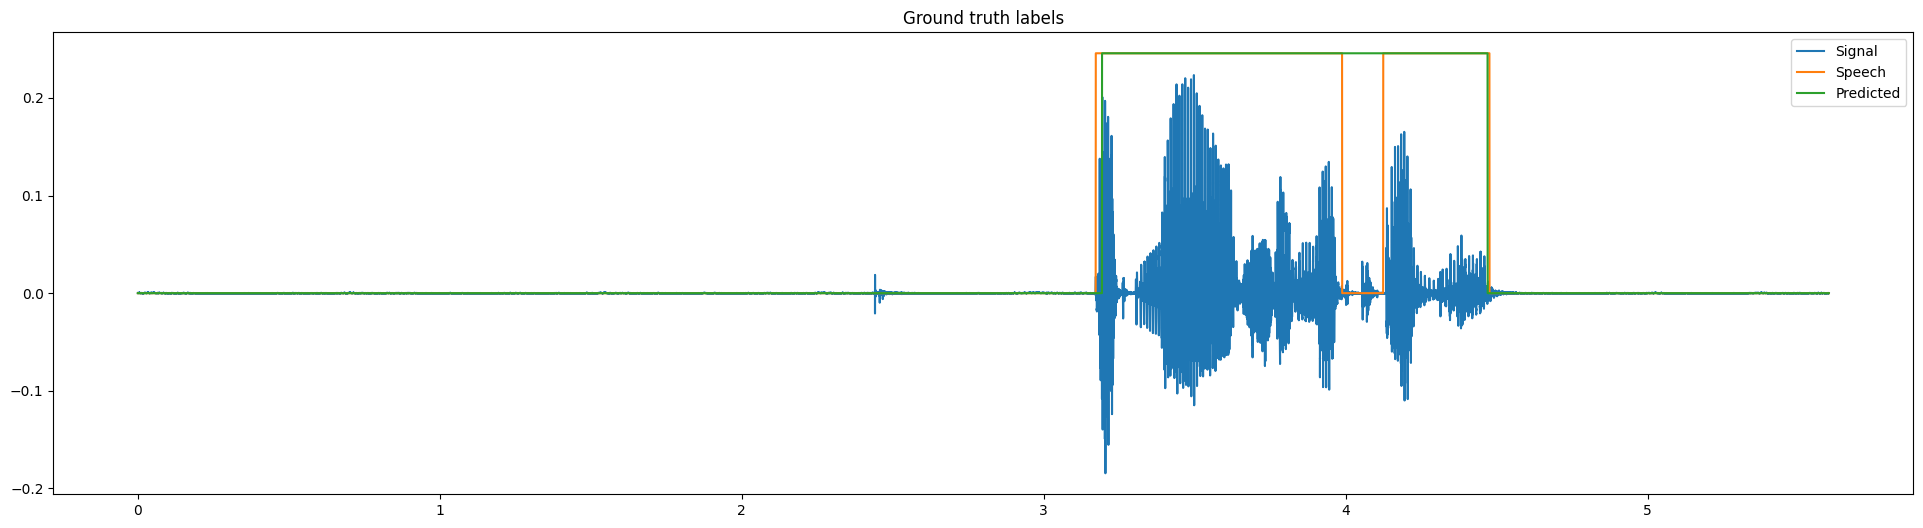

In [49]:
Ns = len(input_signal)  # number of sample
Ts = 1 / fs  # sampling period
t = np.arange(Ns) * Ts  # time axis in seconds
norm_coef = 1.1 * np.max(input_signal)

edge_ind = np.min([input_signal.shape[0], len(truth_labels)])

plt.figure(figsize=(24, 6))
plt.plot(t[:edge_ind], input_signal[:edge_ind])
plt.plot(t[:edge_ind], np.array(truth_labels[:edge_ind]) * norm_coef)
plt.plot(t[:edge_ind], label_timeseries[:edge_ind] * norm_coef)

plt.title("Ground truth labels")
plt.legend(['Signal', 'Speech', 'Predicted'])
plt.show()